In [115]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import create_animation, imshow
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, diffx_tv, diffx_uq, diffy_vq, diffy_tu, filter_apply, filter_iteration, compute_isotropic_KE, compute_isotropic_cospectrum, filter_AD
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-dt', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-layers', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-filters', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-HPF', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-HPF-LPF', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/random-sampled', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-1D/momentum-4-1', additional_subfolder='output', prefix='momentum-4-1')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-1D/HPF', additional_subfolder='output', prefix='HPF')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB-1D/HPF-LPF', additional_subfolder='output', prefix='HPF-LPF')

In [12]:
ds.remesh('R64','R4',compute=True)

Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4


In [13]:
ref = ds['R64_R4'];

# Show cospectra for all models

In [14]:
SGS = ref.SGS_transfer
ZB = ref.transfer(*ref.ZB_offline())
R11 = ref.transfer(*ref.Reynolds(Cr=1,nwidth=1,nselect=1))

In [15]:
SSM11 = ref.transfer(*ref.SSM(C=1,nwidth=1,nselect=1))

In [177]:
Smag = ref.transfer(*ref.Smagorinsky())

In [147]:
ADM11 = ref.transfer(*ref.ADM(C=1,nwidth=1,norder=1))

In [110]:
Jansen = ref.transfer(*ref.JansenHeld(ratio=0.9,nu=xr.DataArray([-130,-50],dims=['zl'])))

In [17]:
EXP205 = ref.transfer(*ref.ZB_offline(LPF_iter=1,LPF_order=4,HPF_iter=2,HPF_order=2,Stress_iter=1,Stress_order=2))

In [150]:
amp = {}
trans = {}
for key in ['ZB', 'ZB11', 'ZB12', 'ZB21', 'ZB22', 'ZB14', 'ZB41', 'ZB44',
            'SSM11', 'SSM12', 'SSM21', 'SSM22', 'SSM41', 'SSM14', 'SSM44',
            'R11', 'R21', 'R12', 'R22', 'R41', 'R14', 'R44', 'ZB11LPF', 'ZBLPF', 
            'EXP205', 'EXP205_noLPF', 'EXP205_onlyHPF',
             'ADM11', 'ZBADM']:
    try:
        amp[key] = ((np.maximum(SGS,0).sum('freq_r') / np.maximum(eval(key),0).sum('freq_r'))).compute()
        trans[key] = amp[key] * eval(key)    
    except:
        pass

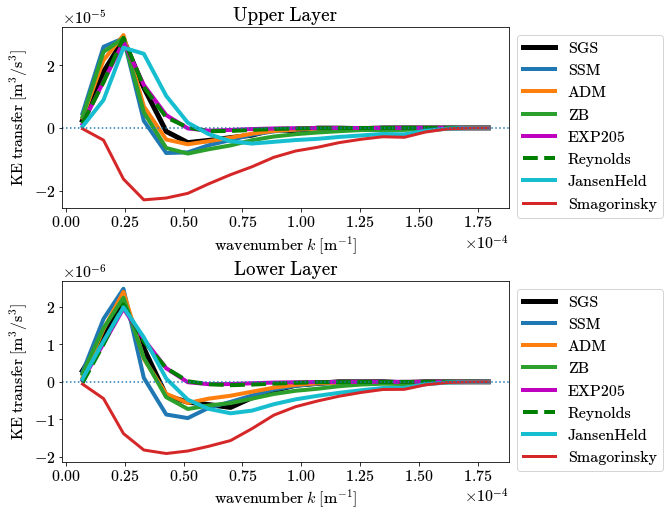

In [186]:
import matplotlib
matplotlib.rcParams.update({'font.family': 'MathJax_Main',
        'mathtext.fontset': 'cm','axes.formatter.limits': (-1,2), 
        'axes.formatter.use_mathtext': True, 'font.size': 16,
        'figure.subplot.hspace': 0.4})
plt.figure(figsize=(8,8))
plt
    
for zl in range(2):
    plt.subplot(2,1,zl+1)
    
    SGS.isel(zl=zl).plot(color='k',lw=5,label='SGS')
    trans['SSM11'].isel(zl=zl).plot(lw=4,label='SSM')
    trans['ADM11'].isel(zl=zl).plot(lw=4,label='ADM')
    trans['ZB'].isel(zl=zl).plot(lw=4,label='ZB')
    trans['EXP205'].isel(zl=zl).plot(lw=4,label='EXP205', color='m')
    trans['R11'].isel(zl=zl).plot(lw=4,label='Reynolds', ls='--', color='g')
    Jansen.isel(zl=zl).plot(lw=4,label='JansenHeld', ls='-', color='tab:cyan')
    Smag.isel(zl=zl).plot(lw=3,label='Smagorinsky')
    plt.axhline(y=0,ls=':')
    if zl==0:
        plt.title('Upper Layer')
    else:
        plt.title('Lower Layer')
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel('wavenumber $k$ [m$^{-1}$]')
    plt.ylabel('KE transfer [m$^3$/s$^3$]')
plt.savefig('Offline-energy-transfer.pdf',bbox_inches='tight')

# Test of filter selectivity

In [112]:
q0 = (ref.h*0 + np.random.randn(*ref.h.shape)).isel(zl=0)

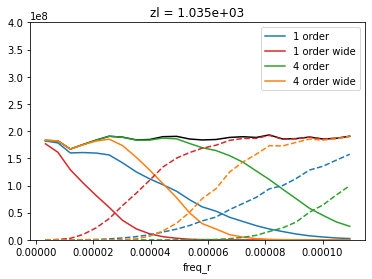

In [114]:
k = ref.power(q,q,Lat=(0,50),Lon=(0,50))['freq_r']
(ref.power(q0,q0,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(color='k')

q = filter_iteration(q0,nwidth=1,nselect=1)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(label='1 order', color='tab:blue')
q = filter_iteration(q0,nwidth=6,nselect=1)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(label='1 order wide', color='tab:red')
q = filter_iteration(q0,nwidth=1,nselect=4)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(label='4 order', color='tab:green')
q = filter_iteration(q0,nwidth=4,nselect=4)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(label='4 order wide', color='tab:orange')

q = filter_iteration(q0,nwidth=1,nselect=1,residual=True)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(ls='--', color='tab:blue')
q = filter_iteration(q0,nwidth=6,nselect=1,residual=True)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(ls='--', color='tab:red')
q = filter_iteration(q0,nwidth=1,nselect=4,residual=True)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(ls='--', color='tab:green')
q = filter_iteration(q0,nwidth=4,nselect=4,residual=True)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(ls='--', color='tab:orange')

plt.ylim([0,4e8])
plt.legend()

# AD filter

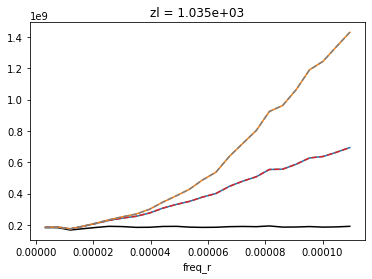

In [122]:
plt.figure()
(ref.power(q0,q0,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(color='k')
q = 2*q0 - filter_apply(q0)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(color='tab:blue')
q = filter_AD(q0,nwidth=1,norder=1)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(color='tab:red', ls='--')
q = 3*q0 - 3*filter_apply(q0) + filter_apply(filter_apply(q0))
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(color='tab:orange', ls='-')
q = filter_AD(q0,nwidth=1,norder=2)
(ref.power(q,q,Lat=(0,50),Lon=(0,50),detrend=None)/k).plot(color='tab:gray', ls='--')

# Test of ZB offline model

In [166]:
import os 
import json
def compute_error(label):
    exp = ds[label]
    folder = exp.folder+'/..'
    with open(os.path.join(folder,'args.json')) as f:
        d = json.load(f)
    print(d)
    fx = exp.mom.ZB2020u
    fy = exp.mom.ZB2020v
    ffx, ffy = exp.ZB_offline(**d)
    fx = select_LatLon(fx)
    fy = select_LatLon(fy)
    ffx = select_LatLon(ffx)
    ffy = select_LatLon(ffy)
    error = Lk_error(ffx.isel(Time=-1),fx.isel(Time=-1)) + Lk_error(ffy.isel(Time=-1),fy.isel(Time=-1))
    return error

In [38]:
compute_error('EXP205-no-trace')

{'resolution': 'R4', 'DAYMAX': 7300.0, 'RESTINT': 1825.0, 'LAPLACIAN': 'False', 'BIHARMONIC': 'True', 'SMAGORINSKY_AH': True, 'SMAG_BI_CONST': 0.03, 'USE_ZB2020': 'True', 'amplitude': 7.0, 'ZB_type': 1, 'ZB_cons': 1, 'LPF_iter': 1, 'LPF_order': 4, 'HPF_iter': 2, 'HPF_order': 2, 'Stress_iter': 1, 'Stress_order': 2}


[0.000627009300613964,
 0.0013680203727900896,
 0.0006376177571907418,
 0.0014506996308712374]

In [4]:
compute_error('EXP205')

{'resolution': 'R4', 'DAYMAX': 7300.0, 'RESTINT': 1825.0, 'LAPLACIAN': 'False', 'BIHARMONIC': 'True', 'SMAGORINSKY_AH': True, 'SMAG_BI_CONST': 0.03, 'USE_ZB2020': 'True', 'amplitude': 7.0, 'ZB_type': 0, 'ZB_cons': 1, 'LPF_iter': 1, 'LPF_order': 4, 'HPF_iter': 2, 'HPF_order': 2, 'Stress_iter': 1, 'Stress_order': 2}


[0.0013508394999851906,
 0.0018097439182950593,
 0.00150977373433652,
 0.0015251861809581076]

In [31]:
(fx,fy) = ds['R16'].ZB_offline()

In [32]:
(fx_c,fy_c) = ds['R16'].ZB_offline_cartesian()

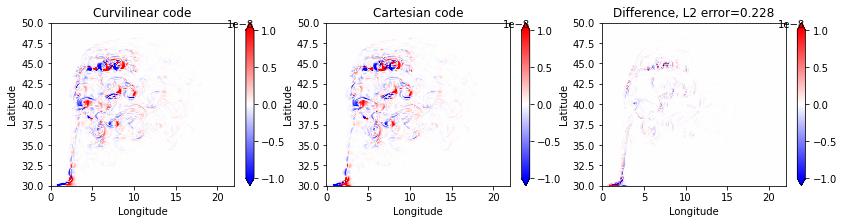

In [33]:
plt.figure(figsize=(14,3))
x = fx.isel(zl=0,Time=-1)
y = fx_c.isel(zl=0,Time=-1)
plt.subplot(1,3,1)
x.plot(vmin=-1e-8,vmax=1e-8,cmap='bwr')
plt.title('Curvilinear code')
plt.subplot(1,3,2)
y.plot(vmin=-1e-8,vmax=1e-8,cmap='bwr')
plt.title('Cartesian code')
plt.subplot(1,3,3)
(x-y).plot(vmin=-1e-8,vmax=1e-8,cmap='bwr')
plt.title(f'Difference, L2 error={round(Lk_error(select_LatLon(y),select_LatLon(x))[0],3)}')
plt.savefig('Cruvilinear-vs-Cartesian.png',dpi=300)

In [34]:
Lk_error(fx.isel(zl=0,Time=-1),fx_c.isel(zl=0,Time=-1))

[0.3484686198257359]

In [237]:
%%time
fx,fy = ds['R4'].ZB_offline()
fx.compute();
fy.compute();

CPU times: user 52 s, sys: 10.4 s, total: 1min 2s
Wall time: 48 s


<xarray.DataArray (yq: 81, xh: 88, zl: 2, Time: 243)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
...
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 21.12 21.38 21.62 21.88
  * yq       (yq) float64 30.0 30.25 30.5 30.75 31.0 ... 49.25 49.5 49.75 50.0
  * zl       (zl) float64 1.035e+03 1.036e+03
  * Time     (Time) float64 30.0 60.0 90.0 120.0 ... 7.23e+03 7.26e+03 7.29e+03

In [244]:
%%time
fx,fy = ds['R4'].ZB_offline(**{'resolution': 'R4', 'DAYMAX': 7300.0, 'RESTINT': 1825.0, 'LAPLACIAN': 'False', 'BIHARMONIC': 'True', 'SMAGORINSKY_AH': True, 'SMAG_BI_CONST': 0.03, 'USE_ZB2020': 'True', 'amplitude': 7.0, 'ZB_type': 0, 'ZB_cons': 1, 'LPF_iter': 1, 'LPF_order': 4, 'HPF_iter': 2, 'HPF_order': 2, 'Stress_iter': 1, 'Stress_order': 2})
fx.compute()
fy.compute()

CPU times: user 2min 47s, sys: 29.7 s, total: 3min 16s
Wall time: 2min 26s


<xarray.DataArray (yq: 81, xh: 88, zl: 2, Time: 243)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
...
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        ...,

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 21.12 21.38 21.62 21.88
  * yq       (yq) float64 30.0 30.25 30.5 30.75 31.0 ... 49.25 49.5 49.75 50.0
  * zl       (zl) float64 1.035e+03 1.036e+03
  * Time     (Time) float64 30.0 60.0 90.0 120.0 ... 7.23e+03 7.26e+03 7.29e+03

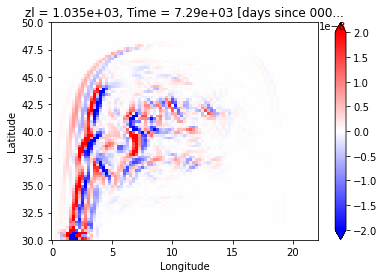

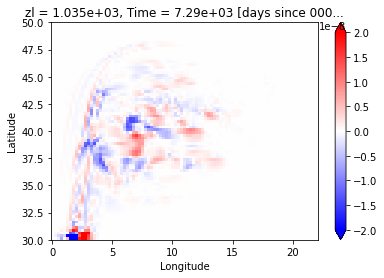

In [269]:
fx,fy = ds['R4'].ZB_offline(ZB_type=1)
fx.isel(Time=-1,zl=0).plot(vmin=-0.2e-7,vmax=0.2e-7,cmap='bwr')
plt.figure()
fx,fy = ds['R4'].ZB_offline()
fx.isel(Time=-1,zl=0).plot(vmin=-0.2e-7,vmax=0.2e-7,cmap='bwr')

# Smagorinsky check

In [169]:
fx0 = ds['Cs-0.1'].smagu
fy0 = ds['Cs-0.1'].smagv

In [170]:
fx, fy = ds['Cs-0.1'].Smagorinsky(Cs=0.1)

In [171]:
print(Lk_error(select_LatLon(fx0),select_LatLon(fx)))
print(Lk_error(select_LatLon(fy0),select_LatLon(fy)))

[0.09641426161927016, 0.1239796554530073]
[0.0959503337099039, 0.1604352959485676]


In [75]:
print(xr.corr(select_LatLon(fx0),select_LatLon(fx)).values)
print(xr.corr(select_LatLon(fy0),select_LatLon(fy)).values)

0.9966301674319359
0.9955988552035995


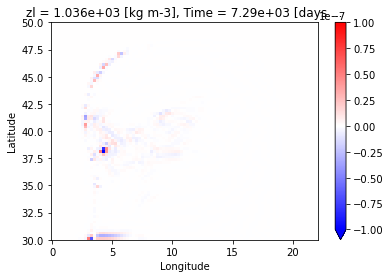

In [72]:
fx0.isel(zl=1,Time=-1).plot(vmin=-1e-7,vmax=1e-7,cmap='bwr')

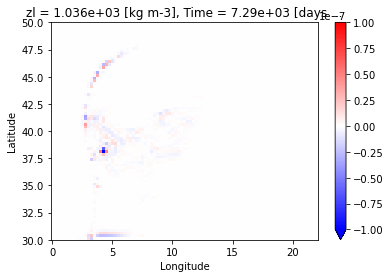

In [73]:
fx.isel(zl=1,Time=-1).plot(vmin=-1e-7,vmax=1e-7,cmap='bwr')

# Linearity in the amplitude

In [80]:
(fx,fy) = ds['R4'].ZB_offline(amplitude=1, **{'LPF_iter': 1, 'LPF_order': 4, 'HPF_iter': 2, 'HPF_order': 2, 'Stress_iter': 1, 'Stress_order': 2})
(fx10,fy10) = ds['R4'].ZB_offline(amplitude=10, **{'LPF_iter': 1, 'LPF_order': 4, 'HPF_iter': 2, 'HPF_order': 2, 'Stress_iter': 1, 'Stress_order': 2})

In [81]:
Lk_error(fx*10,fx10)

[4.999844998154921e-16, 1.3576587151969426e-08]

In [82]:
Lk_error(fy*10,fy10)

[4.2614059427286174e-16, 1.554689982962486e-08]

# Offline analysys of all possible combinations of filters

In [83]:

ds.remesh('R64', 'R4')
exp = ds['R64_R4']

Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4


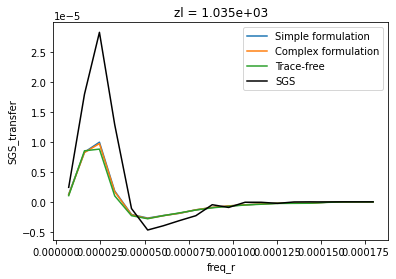

In [211]:
(2/24*xr.open_dataset('ZB_offline.nc').ZB_transfer.isel(zl=0)).plot(label='Complex formulation')
exp.SGS_transfer.isel(zl=0).plot(color='k', label='SGS')
plt.legend()

# Can I pass filter parameters as coordinates?

In [1]:
import xarray as xr

In [3]:
ds = xr.open_dataset('ZB_offline.nc')

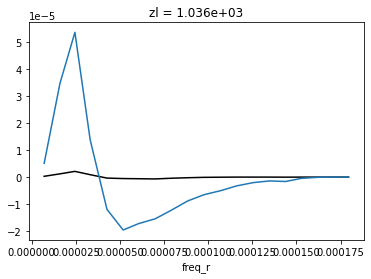

In [18]:
ds.SGS_transfer.isel(zl=1).plot(color='k')
(ds.amp_Eng*ds.ZB_transfer+ds.Smag_transfer).isel(zl=1).plot()

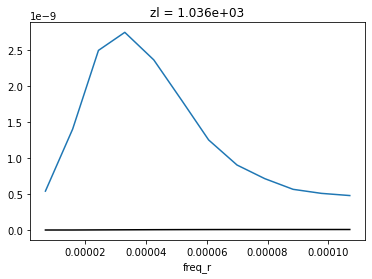

In [23]:
ds.SGS_power.isel(zl=1).plot(color='k')
(ds.amp_Eng**2*ds.ZB_power+ds.Smag_power).isel(zl=1).plot()

In [20]:
ds.corr

<xarray.DataArray 'corr' (zl: 2)>
array([0.312115, 0.349456])
Coordinates:
  * zl       (zl) float64 1.035e+03 1.036e+03

In [21]:
ds.MSE_Eng

<xarray.DataArray 'MSE_Eng' (zl: 2)>
array([ 38.319633, 250.172045])
Coordinates:
  * zl       (zl) float64 1.035e+03 1.036e+03

# Read as a multidimensional array

In [197]:
ds = xr.open_dataset('/scratch/pp2681/mom6/offline/metrics_729/metrics_aggregated.nc')
ds['amp_E'] = (ds.SGS_transfer).sum('freq_r') / (ds.ZB_transfer).sum('freq_r')
ds['amp_E_MSE'] = ((ds.SGS_transfer - ds.Smag_transfer) * ds.ZB_transfer).sum('freq_r') / (ds.ZB_transfer**2).sum('freq_r')
MSE = ((data.SGS_transfer-data.Smag_transfer-ds.amp_E_MSE*data.ZB_transfer)**2).sum(dim=['freq_r','zl'])

In [201]:
d = MSE.argmin(dim=['LPF_iter', 'LPF_order', 'HPF_iter', 'HPF_order', 'Stress_iter', 'Stress_order'])

In [202]:
for key in d.keys():
    print(key, d[key].values)

LPF_iter 0
LPF_order 0
HPF_iter 1
HPF_order 1
Stress_iter 1
Stress_order 2


In [143]:
d = ds.MSE_Eng.argmin(dim=['LPF_iter', 'LPF_order', 'HPF_iter', 'HPF_order', 'Stress_iter', 'Stress_order','zl'])

In [144]:
for key in d.keys():
    print(key, d[key].values)

LPF_iter 0
LPF_order 0
HPF_iter 1
HPF_order 1
Stress_iter 2
Stress_order 1
zl 0


In [203]:
data = ds.sel(LPF_iter=0,LPF_order=0,HPF_iter=1,HPF_order=1,Stress_iter=1,Stress_order=2)

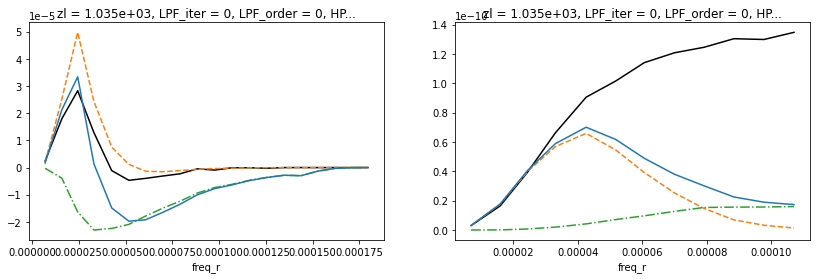

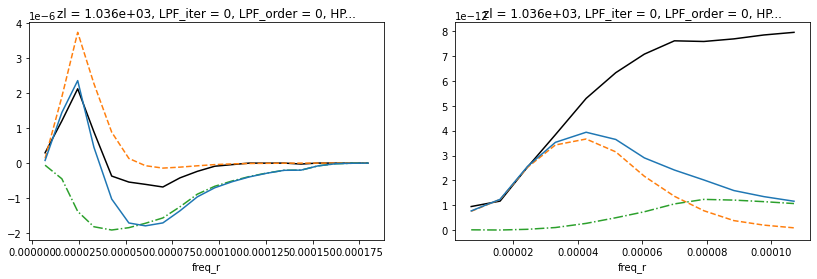

In [204]:
import matplotlib.pyplot as plt
for zl in range(2):
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    data.SGS_transfer.isel(zl=zl).plot(color='k')
    (data.amp_E_MSE*data.ZB_transfer).isel(zl=zl).plot(color='tab:orange',ls='--')
    (data.Smag_transfer).isel(zl=zl).plot(color='tab:green', ls='-.')
    (data.amp_E_MSE*data.ZB_transfer+data.Smag_transfer).isel(zl=zl).plot(color='tab:blue', ls='-')
    plt.subplot(1,2,2)
    data.SGS_power.isel(zl=zl).plot(color='k')
    (data.amp_E_MSE**2*data.ZB_power).isel(zl=zl).plot(color='tab:orange',ls='--')
    (data.Smag_power).isel(zl=zl).plot(color='tab:green', ls='-.')
    (data.amp_E_MSE**2*data.ZB_power+data.Smag_power).isel(zl=zl).plot(color='tab:blue', ls='-')
#    plt.legend()

In [54]:
data.corr.values

array([0.3121149 , 0.34945625], dtype=float32)

In [135]:
data.amp_E_MSE

<xarray.DataArray 'amp_E_MSE' (zl: 2)>
array([0.21740882, 0.22106493], dtype=float32)
Coordinates:
  * zl            (zl) float64 1.035e+03 1.036e+03
    LPF_iter      int64 0
    LPF_order     int64 1
    HPF_iter      int64 0
    HPF_order     int64 1
    Stress_iter   int64 0
    Stress_order  int64 1